# Packages 

In [1]:
from utils_LSTM import *
from metrics_LSTM import *
from metrics_predictions import *

1.13.1
2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7685671695404594061
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6626719826
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2291434767662619228
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Using TensorFlow backend.


# 2 - Dataset and Pre-processing




### 2.1 Initialize parameters and pre-process data

In [2]:
# FILE_PATH = '/home/hummus/algorithms-other/data/airline_tweets.csv'
# FILE_PATH = 'E:/Classification/algorithms-other/data/airline_tweets.csv'

METRIC = "jaccard"

labelled_real=f'../../analysis_jaccard/{METRIC}_labelled_real_text.csv'
labelled_fake=f'../../analysis_jaccard/{METRIC}_labelled_fake_text.csv'
labelled_fake1=f'../../analysis_word_emb/wmd_labelled_fake_text.csv'


real_data = pd.read_csv(labelled_real)
fake_data = pd.read_csv(labelled_fake)
fake_data1 = pd.read_csv(labelled_fake1)

# real_data['text'] = real_data['text'].astype('str').str.lower()
# mask = (real_data['text'].str.len() >= 20)
# real_data = real_data[mask]

# fake_data['text'] = fake_data['text'].astype('str')
# mask = (fake_data['text'].str.len() >= 20)
# fake_data = fake_data[mask]

print(fake_data.head(10))

# fake_data = fake_data[len(real_data['text'].split()) >= 20]

combined_data = real_data.append(fake_data)
# combined_data = combined_data.append(fake_data1)

y = combined_data['label'].values

# file_dir = os.path.dirname(os.path.realpath('__file__'))
# filename = os.path.join(file_dir, filepath)
# filename = os.path.abspath(os.path.realpath(filename))

# data = pd.read_csv(filename)

# sequences = get_sequences(max_features=5000, data=combined_data)

# x = sequences # pre-processed data from step 3
# print(x)
y = pd.get_dummies(combined_data['label']).values #turn sentiments into 0 and 1 into a (11538,2) matrix
print(y)

# DATASET = 'airline' #options: 'airline', 'products','apple','self-driving-cars', 'ied'
samples = -1 #number of samples to select from the dataset
# cols = [1,10] #columns [1,3] or [1,10] to use from dataset (target and text columns)

max_features = 5000 #number of words to consider as features    
max_len = 50# Maximum sequence length-- used in Section 5 for predictions

data = combined_data

#-----Pre-process and tokenize data into sequences-----# 
# data, pos_sent_size, neg_sent_size, neut_sent_size = data_preprocess(samples, DATASET, FILE_PATH, cols, labels = True)
sequences,tokenizer = keras_tokenizer(data, max_features,'text', max_len)

# print('Number of positive sentiments:', pos_sent_size)
# print('Number of negative sentiments:', neg_sent_size)
# print('Number of neutral sentiments:', neut_sent_size)
print('The dimensions of the matrix with all sequences is:', sequences.shape)
print('Sequence corresponding to a tweet:\n', sequences[0])
pd.set_option('max_colwidth', 100) #sets columns width in DataFrame
data.head()

   index                                               text   novelty  \
0      0  the scottish government has won and not necess...  0.718750   
1      1  the more of the main people do not to not pay ...  0.666667   
2      2  it was a shame , but when they put it up for h...  0.676471   
3      3  `` it took me , but that is a good thing , but...  0.600000   
4      4  `` i didn ' t have that a citizen of the famil...  0.666667   
5      5  we need to be , but `` that ' s just a chance ...  0.611111   
6      6  it is a better option that ' s a brexit , or m...  0.687500   
7      7  and it is ten and are not required to make it ...  0.625000   
8      8  you need to be ready , but they can draw atten...  0.687500   
9      9  `` the only thing that you are able to do anyt...  0.558824   

   diversity  label  
0   0.645161      0  
1   0.586207      0  
2   0.612903      0  
3   0.407407      0  
4   0.566667      0  
5   0.531250      0  
6   0.666667      0  
7   0.645161      0 

,index,text,novelty,diversity,label
0,0,What this group does is to take down various different websites it believes to be criminal and l...,0.750000,0.787879,1
1,1,"Over 1 , 600 a day have reached Greece this month , a higher rate than last July when the crisis...",0.694444,0.785714,1
2,2,"We ' re working through a legacy period , with legacy products that are 10 or 20 years old ,"" he...",0.676471,0.743590,1
3,3,"The first time anyone says you need help , I ' m on the defensive , but that ' s all that I know .",0.628571,0.684211,1
4,4,"Out of those who came last year , 69 per cent were men , 18 per cent were children and just 13 p...",0.703704,0.718750,1


# 3 - Split data into train and test sets

In [3]:
x = sequences # pre-processed data in the form of sequences from step 2
input_length =sequences.shape[1]
y = pd.get_dummies(data['label']).values #turn sentiments into 0 and 1 into a (11538,2) matrix
test_size=.10
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = test_size, random_state = 42) #random state to get same split output (42, 0, 21)
print('input dimensions:', x.shape, '|', 'output dimensions:', y.shape)
print('x_train dimensions:', x_train.shape, '|', 'y_train dimensions:', y_train.shape)
print('x_test dimensions:', x_test.shape, '|', 'y_test dimensions:', y_test.shape)

input dimensions: (21554, 50) | output dimensions: (21554, 2)
x_train dimensions: (19398, 50) | y_train dimensions: (19398, 2)
x_test dimensions: (2156, 50) | y_test dimensions: (2156, 2)


# 4 - LSTM Model Training and Validation

Hyperparameters: embedding dimensions, hidden units and batch size (embedding_dim, units, batch_size)

The number of parameters in the model are given by:

$$ p = 4*(nm + n^2 + n)$$ 

**where:**

m = number of embeddings per word

n = output dimension of the lstm

p = number of parameters in the LSTM model

### 4.1 Initialize model parameters

In [4]:
# #-----Initialize model parameters-----# 
# embedding_dim=400
# units=250 
# batch_size=32
# max_len = 30 # Cuts off texts after this many words (among the max_features most common words)-- used in Section 5 for predictions
# epochs = 12
# #-----Initialize k-fold splits-----# 
# splits = 4 #number of fold for cross-validation (used in Section 4.3)
#-----Initialize model parameters-----# 
embedding_dim=10000
units=300
batch_size=256
epochs = 4
#-----Initialize k-fold splits-----# 
splits = 10 #number of fold for cross-validation (used in Section 4.3)

### 4.2 Build and train model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 10000)         50000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 10000)         0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 300)               12362400  
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 62,392,702
Trainable params: 62,392,702
Non-trainable params: 0
_________

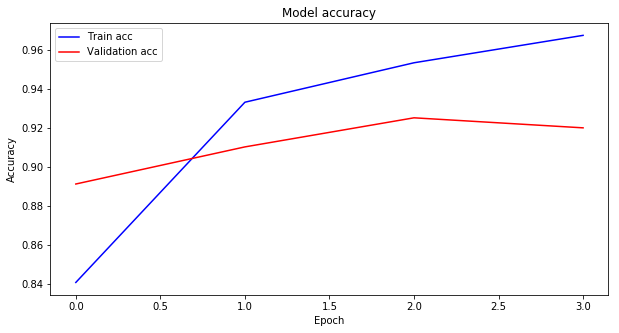

FileNotFoundError: [Errno 2] No such file or directory: '/home/hummus/algorithms-other/LSTM/figures/learning/learning_performance__-1_batchsize256_maxlen50_epochs4.png'

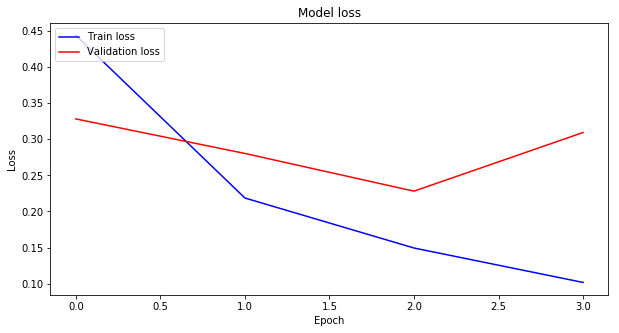

In [5]:
# np.random.seed(seed) # do not modify-used to get reproducible data analysis results

#-----Build LSTM model with Keras-----#      
keras_model = lstm_closure(embedding_dim, units, batch_size, max_features, input_length) #function that references create_lstm_model() in its enclosing scope
model = keras_model() # call to nested function in lstm_closure(...); returns Keras model
history = model.fit(x_train, y_train, validation_split=test_size, epochs=epochs, batch_size=batch_size, verbose=1)
min_epoch= plot_learning_performance(history, '', samples, batch_size, max_len, epochs)
print("Minimum validation loss is reached in epoch {}".format(min_epoch))

### 4.3 k-Fold Cross-validation

In [10]:
#-----Perform cross-validation with Scikit Learn-----#    
classifier = KerasClassifier(build_fn= keras_model, epochs = epochs, batch_size=batch_size, verbose = 1)
scores = cross_validate(classifier, x_train, y_train, cv=splits, verbose =1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 10000)         50000000  
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 50, 10000)         0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 300)               12362400  
_________________________________________________________________
dense_14 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 62,392,702
Trainable params: 62,392,702
Non-trainable params: 0
_________________________________________________________________
None


InternalError: GPU sync failed

In [7]:
print(scores)
# print(sorted(scores.keys())) 

#using K-fold Cross-validation  as a measure of model performance
print("(k-fold model performance, w/o optimisation) Accuracy = %0.4f , SD = +/- %0.4f" % (scores['test_score'].mean(), scores['test_score'].std() * 2))


NameError: name 'scores' is not defined

# 5 - Model Metrics


### 5.1 Run Metrics- using Keras predict and without cross validation

In [12]:
# %run metrics_LSTM.py

Classification accuracy for positive tweets 74.15254237288136 %
Classification accuracy for negative tweets 96.62309368191721 %


FileNotFoundError: [Errno 2] No such file or directory: '/home/hummus/algorithms-other/LSTM/figures/auc_roc/auc_roc_airline_-1_batchsize256_maxlen32_epochs4.png'

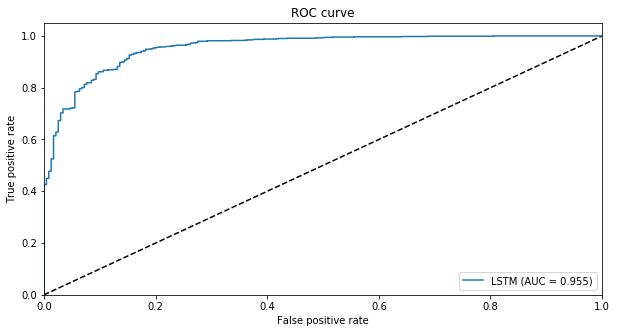

In [9]:
#-----Classification accuracy for positive and negative tweets-----#
pos_correct, pos_cnt, neg_correct, neg_cnt = accuracy_neg_pos(x_test, y_test, model, max_len)
print("Classification accuracy for positive tweets", pos_correct/pos_cnt*100, "%")
print("Classification accuracy for negative tweets", neg_correct/neg_cnt*100, "%")


# #-----k-fold validation accuracy scores-----#
# print('Test scores (k-fold):', scores['test_score'])
# print('Train scores (k-fold):', scores['train_score'])
# #using K-fold Cross-validation  as a measure of model performance
# print("(k-fold model performance, w/o optimisation) Accuracy = %0.4f , SD = +/- %0.4f" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

#-----ROC/AUC-----#
auc_keras,fpr_keras,tpr_keras=auc_roc(x_test,y_test,model, max_len)
plot_LSTM=plot_auc_roc(auc_keras,fpr_keras,tpr_keras, "", samples, batch_size, max_len,epochs)

#-----Confusion Matrix-----#
y_pred=keras_predict(x_test, 'all', model, max_len)
# classifier.fit(x_train, y_train)
# y_pred=classifier.predict_proba(x_test)
predicted = np.argmax(y_pred, axis =1)
actual = pd.Series(np.where(y_test!=0)[1]).values
# print('Confusion Matrix:')
# matrix=confusion_matrix(actual,predicted)
# print(matrix)
# plot_confusion_matrix(actual, predicted, classes=data.target.values,
#                       title='Confusion matrix, without normalization')
plot_confusion_matrix(actual, predicted, classes=data.target.values,normalize=True,
                      title='Normalized confusion matrix')

#-----Classification Report-----#
report=classification_report(actual, predicted, digits =3) 
print('Classification Report:')
print(report)

print('Cross entropy:', log_loss(y_test,y_pred, normalize=True))
print('Accuracy score:', accuracy_score(actual, predicted, normalize=True))




# plt.figure(1)
# plt.subplot(1,2,1)
# plt.imshow(plot_matrix)

# plt.subplot(1,2,2)
# plt.imshow(plot)
# plt.show()


### 5.2 Run Metrics- using scikit-learn predict and with cross validation

In [14]:
# %run metrics_LSTM.py

In [15]:
#-----Classification accuracy for positive and negative tweets-----#
classifier.fit(x_train, y_train)
predictions = classifier.predict_proba(x_test)#returns logits

pos_correct, pos_cnt, neg_correct, neg_cnt = accuracy_neg_pos_scikit(x_test, y_test,predictions)
print("Classification accuracy for positive tweets", pos_correct/pos_cnt*100, "%")
print("Classification accuracy for negative tweets", neg_correct/neg_cnt*100, "%")


# #-----k-fold validation accuracy scores-----#
# print('Test scores (k-fold):', scores['test_score'])
# print('Train scores (k-fold):', scores['train_score'])

#-----ROC/AUC-----#
# auc_keras,fpr_keras,tpr_keras=auc_roc(x_test,y_test,model, max_len)
# plot=plot_auc_roc(auc_keras,fpr_keras,tpr_keras, DATASET, samples, batch_size, max_len,epochs)

# #-----Confusion Matrix-----#
# # y_pred=keras_predict(x_test, 'all', model, max_len)
# classifier.fit(x_train, y_train)
# y_pred=classifier.predict_proba(x_test)
# predicted = np.argmax(y_pred, axis =1)
# actual = pd.Series(np.where(y_test!=0)[1]).values
# # print('Confusion Matrix:')
# # matrix=confusion_matrix(actual,predicted)
# # print(matrix)
# # plot_confusion_matrix(actual, predicted, classes=data.target.values,
# #                       title='Confusion matrix, without normalization')
# plot_confusion_matrix(actual, predicted, classes=data.target.values,normalize=True,
#                       title='Normalized confusion matrix')
# #-----Classification Report-----#
# report=classification_report(actual, predicted) 
# print('Classification Report:')
# print(report)

# print('Cross entropy:', log_loss(y_test,y_pred, normalize=True))
# print('Accuracy score:', accuracy_score(actual, predicted, normalize=True))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 32, 10000)         20000000  
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 32, 10000)         0         
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 300)               12362400  
_________________________________________________________________
dense_22 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 202       
Total params: 32,392,702
Trainable params: 32,392,702
Non-trainable params: 0
_________________________________________________________________
None


/home/hummus/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
 - 6s - loss: 0.4851 - acc: 0.8325
Epoch 2/4
 - 4s - loss: 0.2730 - acc: 0.9294
Epoch 3/4
 - 4s - loss: 0.1927 - acc: 0.9482
Epoch 4/4
 - 4s - loss: 0.1398 - acc: 0.9602
Classification accuracy for positive tweets 79.23728813559322 %
Classification accuracy for negative tweets 95.31590413943356 %


In [16]:
# print(len(predictions))
# predicted_sent_index = np.argmax(predictions[x])
# print(predicted_sent_index)

# 6 - Display Predictions  ##

### 6.1 - Display predictions on  ***test set***

In [17]:
df = display_predictions(x_test, tokenizer, model,max_len)
qgrid_widget = qgrid.show_grid(df)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### 6.2 Compare to expected labels

In [18]:

df_y_test=pd.DataFrame(actual,columns=['Labels'])
df_y_test['Labels'] = df_y_test['Labels'].apply(lambda x: 'negative' if x == 1 else 'positive')
print(df_y_test.shape)
# df_y_test.head(100)

(1154, 1)


In [19]:
df= df.set_index(df_y_test.index)
compare= pd.concat([df, df_y_test], axis =1)
compare.head()


,Sentiment Probabilities,Text,Sentiment Prediction,Labels
0,"[0.0010022541, 0.99899775]",terrible response how about someone up the phone and calling is now hours with no luggage,negative,negative
1,"[0.00014213975, 0.9998578]",asked her why needed to take tag off she said because i told you to expect a personal apology fr...,negative,negative
2,"[0.0006919486, 0.999308]",how can i speak to a human need 2 find bag delayed website and 800 are telling me 2 different th...,negative,negative
3,"[0.008559581, 0.9914404]",no first class passenger should have to pay for inflight wifi,negative,negative
4,"[0.08639281, 0.9136072]",your loyalty team basically me off via phone but thanks maybe loyalty and get back to me lol,negative,negative


### 6.2 Export predictions to csv file

In [20]:
#export as csv
compare.to_csv(f'/home/hummus/algorithms-other/LSTM/predictions/{DATASET}_{samples}_batchsize{batch_size}_maxlen{max_len}_epochs{epochs}.csv', index=False, header= True)

## 7 - Save and Load Model

#### 7.1 Set Filename to Save / Load Model

In [21]:
def set_filename_keras():
    path = '/home/hummus/algorithms-other/LSTM/saved_models/'
    now = datetime.now()
    file_name = f'{path}LSTM_keras_model_{DATASET.upper()}_{samples}_epochs{epochs}_batchsize{batch_size}_units{units}_maxlen{max_len}_emb{embedding_dim}_'
    file_name += str(now.strftime("%d%m%Y_%H-%M-%S"))
    file_name += ".h5"
    return file_name

def set_filename_parameters():
    path = '/home/hummus/algorithms-other/LSTM/saved_models/'
    now = datetime.now()
    file_name = f'{path}LSTM_parameters_{DATASET.upper()}_{samples}_epochs{epochs}_batchsize{batch_size}_units{units}_maxlen{max_len}_emb{embedding_dim}_'
    file_name += str(now.strftime("%d%m%Y_%H-%M-%S"))
    file_name += ".pkl"
    return file_name

#### 7.2 - Save Model ##

In [22]:
# save the parameters to disk using pickle
filename = set_filename_parameters()
with open(filename, 'wb') as f:
    pickle.dump([data, y, x_train, x_test, y_train, y_test, batch_size, tokenizer, max_features, max_len, samples,epochs, auc_keras,fpr_keras,tpr_keras, scores, splits, DATASET] , f)

# save the model to disk using keras/tf
filename = set_filename_keras()
model.save(filename)

#### 7.3 - Load Model ##

In [ ]:
# load the parameters from disk using pickle
# path_load = '/home/hummus/algorithms-other/LSTM/saved_models/'
path_load = '/home/hummus/algorithms-other/LSTM/saved_models/'
pkl_file ='LSTM_parameters_ALL_-1_epochs4_batchsize256_units300_maxlen32_emb10000_16052019_14-36-30.pkl'
with open (f'{path_load}{pkl_file}', 'rb') as f:
    data, y, x_train, x_test, y_train, y_test, batch_size, tokenizer, max_features, max_len, samples,epochs, auc_keras,fpr_keras,tpr_keras, scores,splits, DATASET = pickle.load(f)

# load the model from disk using keras/tf
h5_file= 'LSTM_keras_model_ALL_-1_epochs4_batchsize256_units300_maxlen32_emb10000_16052019_14-36-30.h5'
load_model = keras.models.load_model(f'{path_load}{h5_file}')
model = load_model

## 8 - Generalization ##

 Run trained model on unseen data.

### 8.1 Pre-process data ##

In [ ]:
FILE_PATH_G ='/home/hummus/algorithms-other/data/all/test.tsv' #'/home/hummus/algorithms-other/data/all/test.tsv' 
DATASET_G= 'all'
cols_g = [0,1,2] #columns to use from dataset (target and text columns)
labels = False
samples_g = -1 #read all data

# FILE_PATH_G = '/home/hummus/algorithms-other/data/airline_tweets.csv' # 'E:/algorithms-other/self_drive_cars.csv' 
# DATASET_G= 'airline'
# cols_g = [1,10] #columns to use from dataset (target and text columns)
# samples_g = -1 #read all data

#-----Pre-process and tokenize data into sequences-----#     
data_g, pos_sent_size_g, neg_sent_size_g, neut_sent_size_g = data_preprocess(samples_g, DATASET_G, FILE_PATH_G, cols_g, labels)
data_g = data_g.sort_values(by = 'id')
sequences_g,tokenizer_g = keras_tokenizer(data_g, max_features,'text', max_len)

if pos_sent_size_g or neg_sent_size_g or neut_sent_size_g != None:
    target_g = pd.get_dummies(data_g['target']).values #dummy/indicator variable
    
print('Number of positive sentiments:', pos_sent_size_g)
print('Number of negative sentiments:', neg_sent_size_g)
print('Number of neutral sentiments:', neut_sent_size_g)

# print(data_g.shape)
# print(sequences_g.shape)
# print(sequences.shape)

pd.set_option('max_colwidth', 200) #sets columns width in DataFrame
data_g.tail(10)


In [ ]:
text = tokenizer.sequences_to_texts(sequences_g)
text_df = pd.DataFrame()
text_df['text'] =text
text_df.tail()

### 8.2 Detect language and remove non-english text

In [ ]:
data_english_only=detect_language(data_g)
data_g.head()

### 8.3  Run trained model and predict sentiment on unseen data ##

In [ ]:
# #predict values on unlabelled data
# if pos_sent_size_g == None and neg_sent_size_g == None and neut_sent_size_g == None:

#     test_data = pd.read_csv('E:/algorithms-other/data/all/test.tsv', sep ='\t', header= None, names =['id','text','target']) # Keeping only the necessary columns
#     test_data = test_data.sort_values(by = 'id')

#     predictions_g=keras_predict(sequences_g,'all',model, max_len)
#     dataset = pd.DataFrame({'pos':predictions_g[:,0],'neg':predictions_g[:,1]})
#     probs= dataset[['pos','neg']]
#     probs['prediction'] = probs.idxmax(axis=1)
# #     probs['prediction'] = probs['sentiment'].apply(lambda x: 1 if x == 'neg' else 0)
#     # # display test labels as 'pos' and 'neg' instead of integers-- this is for display purposes only
#     sent_label = pd.DataFrame()
#     sent_label['target'] = test_data['target'].apply(lambda x: 'neg' if x == 1 else 'pos') 
#     df_g = pd.concat([data_g, probs, sent_label], axis =1)
#     target_g = pd.get_dummies(df_g['target']).values
    
   
    
# #predict values on labelled data
# else:
#     predictions_g=keras_predict(sequences_g,'all',model, max_len)
#     df_g = display_predictions(sequences_g, tokenizer_g, model, max_len)

# qgrid_widget_g = qgrid.show_grid(df_g)
# qgrid_widget_g
# pd.set_option('max_colwidth', 200) #sets columns width in DataFrame
# # df_g['id'].astype('int')
# test_data.tail()
# # df_g.tail()
# # df_g.info()

In [ ]:
#predict values on unlabelled data
if pos_sent_size_g == None and neg_sent_size_g == None and neut_sent_size_g == None:

#     test_data = pd.read_csv('E:/algorithms-other/data/all/test.tsv', sep ='\t', header= None, names =['id','text','target']) # Keeping only the necessary columns
#     test_data = test_data.sort_values(by = 'id')

    predictions_g=keras_predict(sequences_g,'all',model, max_len)
    dataset = pd.DataFrame({'pos':predictions_g[:,0],'neg':predictions_g[:,1]})
    probs= dataset[['pos','neg']]
    probs['prediction'] = probs.idxmax(axis=1)
#     probs['prediction'] = probs['sentiment'].apply(lambda x: 1 if x == 'neg' else 0)
    # # display test labels as 'pos' and 'neg' instead of integers-- this is for display purposes only
    sent_label = pd.DataFrame()
    sent_label['target'] = data_g['test_label'].apply(lambda x: 'neg' if x == 1 else 'pos') 
    df_g = pd.concat([data_g, probs, sent_label], axis =1)
    target_g = pd.get_dummies(df_g['target']).values
    
   
    
#predict values on labelled data
else:
    predictions_g=keras_predict(sequences_g,'all',model, max_len)
    df_g = display_predictions(sequences_g, tokenizer_g, model, max_len)

# qgrid_widget_g = qgrid.show_grid(df_g)
# qgrid_widget_g
pd.set_option('max_colwidth', 200) #sets columns width in DataFrame
# df_g['id'].astype('int')
df_g.tail()
# df_g.info()

In [ ]:
#-----Classification accuracy for positive and negative tweets-----#
pos_correct_g, pos_cnt_g, neg_correct_g, neg_cnt_g = accuracy_neg_pos_test(df_g)
print("Classification accuracy for positive tweets", pos_correct_g/pos_cnt_g*100, "%")
print("Classification accuracy for negative tweets", neg_correct_g/neg_cnt_g*100, "%")

#-----ROC/AUC-----#
auc_keras,fpr_keras,tpr_keras, actual_g, predicted_g=auc_roc_test(df_g)
plot=plot_auc_roc_test(auc_keras,fpr_keras,tpr_keras)

# #-----Confusion Matrix-----#
if pos_sent_size_g == None and neg_sent_size_g == None and neut_sent_size_g == None:
    classes = target_g
else:
    classes = data_g.target.values

matrix=plot_confusion_matrix_test(actual_g,predicted_g, classes=classes, normalize=True,
                                   title='Normalized confusion matrix')

# #-----Classification Report-----#
report=classification_report(actual_g, predicted_g) 
print('Classification Report (generalization):')
print(report)

In [ ]:
# #-----Classification accuracy for positive and negative tweets-----#
# pos_correct_g, pos_cnt_g, neg_correct_g, neg_cnt_g = accuracy_neg_pos(sequences_g, target_g, model, max_len)
# print("Classification accuracy for positive tweets", pos_correct_g/pos_cnt_g*100, "%")
# print("Classification accuracy for negative tweets", neg_correct_g/neg_cnt_g*100, "%")

# #-----ROC/AUC-----#
# auc_keras,fpr_keras,tpr_keras=auc_roc(sequences_g,target_g, model, max_len)
# plot=plot_auc_roc(auc_keras,fpr_keras,tpr_keras, DATASET_G, samples, batch_size, max_len)

# #-----Confusion Matrix-----#
# predicted_g = np.argmax(predictions_g, axis =1)
# actual_g = pd.Series(np.where(target_g!=0)[1]).values
# matrix=confusion_matrix(actual_g,predicted_g)


# if pos_sent_size_g == None and neg_sent_size_g == None and neut_sent_size_g == None:
#     classes = target_g
# else:
#     classes = data_g.target.values

# plot_confusion_matrix(actual_g, predicted_g, classes=classes,normalize=True,
#                       title='Normalized confusion matrix')

# #-----Classification Report-----#
# report=classification_report(actual_g, predicted_g) 
# print('Classification Report (generalization):')
# print(report)

### 8.4 Export predictions to csv file

In [ ]:
#export as csv
file_path_export = f'/home/hummus/algorithms-other/LSTM/predictions/'
now = datetime.now()
time_stamp = str(now.strftime("%d%m%Y_%H-%M-%S"))
df_g.to_csv(f'{file_path_export}gen_{DATASET_G}_{samples}_unit{units}_batchsize{batch_size}_maxlen{max_len}_epochs{epochs}_embeddings{embedding_dim}_{time_stamp}.csv', index=False, header= True)